In [49]:
import copy
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear
import torch.optim as optim
from torch_geometric import nn
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import GCNConv
from torch_geometric.nn import VGAE

from torch_geometric.nn import global_max_pool
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.inits import reset

from torch_geometric.transforms import remove_isolated_nodes
import torch_geometric.utils as utils


In [50]:
K = 15 # top-K

# Import the dataset


In [51]:
# Load the dataset
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG')

# Divise in train and test set
train = dataset[:int(len(dataset)*.8)]
test = dataset[int(len(dataset)*.8):]

# Use the DataLoader class to create a batch iterator
batch = 32
train_loader = DataLoader(train, batch_size=batch, shuffle=True)
test_loader = DataLoader(test, batch_size=batch, shuffle=False)

# Create a pretained GNN


## Create the model


In [52]:
class GraphNet(torch.nn.Module):
    def __init__(self, num_features=dataset.num_features, num_classes=dataset.num_classes):
        super(GraphNet, self).__init__()
        self.conv1 = GCNConv(num_features, 20)
        self.conv2 = GCNConv(20, 20)
        self.conv3 = GCNConv(20, 20)
        self.fc = Linear(20*3, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x1 = self.conv1(x, edge_index).relu()
        x2 = self.conv2(x1, edge_index).relu()
        x3 = self.conv3(x2, edge_index).relu()
        x = torch.cat([x1, x2, x3], dim=-1)
        x = global_max_pool(x, data.batch)
        x = self.fc(x)
        return x

model_backup = GraphNet()
print(model_backup)

GraphNet(
  (conv1): GCNConv(7, 20)
  (conv2): GCNConv(20, 20)
  (conv3): GCNConv(20, 20)
  (fc): Linear(in_features=60, out_features=2, bias=True)
)


## Train the model


Epoch 1000/1000: Loss = 0.4268, Accuracy = 0.8108


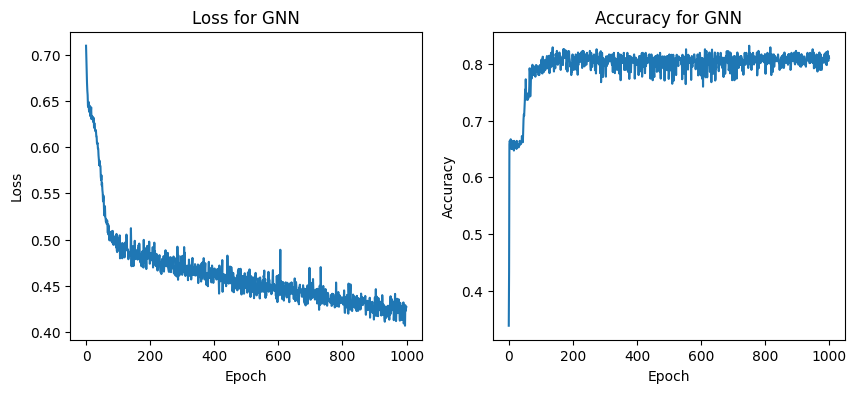

In [53]:
model =  copy.deepcopy(model_backup)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# List for plots
losses = []
accuracies = []

# Set the model to training mode
model.train()

# Training loop
for epoch in range(num_epochs):
    # Initialize variables for tracking loss and accuracy
    total_loss = 0
    total_accuracy = 0
    
    # Iterate over the batches in the train_loader
    for data in train_loader:
        
        # Reset the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, data.y)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Update the total loss
        total_loss += loss.item()
        
        # Calculate the accuracy
        pred_y = output.argmax(dim=1)
        acc = accuracy(pred_y, data.y)
        
        # Update the total accuracy
        total_accuracy += acc.item()
    
    # Calculate the average loss and accuracy for the epoch
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader)
    losses.append(avg_loss)
    accuracies.append(avg_accuracy)
    
    # Print the epoch number, loss, and accuracy
    if epoch == num_epochs-1:
        print(f"Epoch {epoch+1}/{num_epochs}: Loss = {avg_loss:.4f}, Accuracy = {avg_accuracy:.4f}")


# Plot the loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Loss for GNN")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title("Accuracy for GNN")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## Test the trained GNN


In [54]:
# Set the model to evaluation mode
model.eval()

# Initialize variables for tracking loss and accuracy
total_loss = 0
total_accuracy = 0

# Iterate over the batches in the test_loader
for graph in test_loader:
    # Forward pass
    output = model(graph)
    
    # Calculate the loss
    loss = criterion(output, graph.y)
    
    # Update the total loss
    total_loss += loss.item()
    
    # Calculate the accuracy
    pred_y = output.argmax(dim=1)
    acc = accuracy(pred_y, graph.y)
    
    # Update the total accuracy
    total_accuracy += acc.item()

# Calculate the average loss and accuracy for the test set
avg_loss = total_loss / len(test_loader)
avg_accuracy = total_accuracy / len(test_loader)

# Print the average loss and accuracy
print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_accuracy:.4f}")


Test Loss: 0.5652, Test Accuracy: 0.7604


# Distillation process


In [55]:
class Distillation():
    def __init__(self, model, criterion=torch.nn.CrossEntropyLoss(), K=K, connected=False):
        self.K = K*2
        self.connected = connected
        self.model = model
        self.criterion = criterion

    def process(self, graphs):
        subgraphs = []
        for graph in graphs:
            subgraph = self.one_graph(graph)
            subgraphs.append(subgraph)
        return subgraphs

    
    def one_graph(self, graph):
        Ec_sorted = sorted(self.get_causal_contributions(graph), key=lambda x: x[1], reverse=False)
        Gs = copy.copy(graph)
        Gs, Es = self.apply_weights(Gs, Ec_sorted)
        Es_sorted = sorted(Es, key=lambda x: x[1], reverse=False)
        Gs = self.distill(Gs, Es_sorted)
        return Gs


    ###### Process functions ######
    def get_causal_contributions(self, graph):
        """
        Get the causal contributions for all edges in the graph

        Args:
            graph (torch_geometric.data.Data): The graph

        Returns:
            list: A list of tuples containing the edge and its causal contribution
        """
        causal_contributions = []
        for edge in graph.edge_index.t().tolist():
            delta = self.causal_contribution(graph, edge)
            causal_contributions.append((edge, delta))
        return causal_contributions

    def apply_weights(self, graph, edges):
        """
        Calculate the weights for the edges

        Args:
            graph (torch_geometric.data.Data): The graph
            edges (list): A list of edges

        Returns:
            torch_geometric.data.Data: The graph with the weights applied
            list: A list of tuples containing the edge and its weight
        """
        weights_list = []
        for edge, causal_contribution in edges:
            graph_ = self.remove_edge(graph, edge)
            if graph_.edge_index.size(1) == 0:
                break
            if self.connected:
                pass
            loss = self.criterion(self.model(graph), graph.y)
            loss_ = self.criterion(self.model(graph_), graph_.y)
            if  loss_ > loss:
                weight = (loss - loss_).item()
                weights_list.append((edge, weight))
            else:
                graph = copy.deepcopy(graph_)
                if graph.edge_index.size(1) <= K: # if the graph has not enough important edges 
                    return graph, weights_list
        return graph, weights_list
    
    def distill(self, graph, edges):
        """
        Distill the subgraph with top-k most relevant edges

        Args:
            graph (torch_geometric.data.Data): The graph
            edges (list): A list of edges sorted by weight

        Returns:
            torch_geometric.data.Data: The distilled subgraph
        """
        for edge, weight in edges:
            if len(graph.edge_index.t()) > self.K:
                graph = self.remove_edge(graph, edge)
                if self.connected:
                    pass
        return graph

    ###### Helper functions ######
    def remove_edge(self, graph, edge):
        """
        Remove an edge from the graph

        Args:
            graph (torch_geometric.data.Data): The graph
            edge (tuple): The edge to remove

        Returns:
            torch_geometric.data.Data: The graph without the edge
        """
        edges = []
        for e in graph.edge_index.t().tolist():
            if e != edge and e != edge[::-1]: # Remove the edge and its reverse because the graph is undirected
                edges.append(e)
        graph_ = copy.deepcopy(graph)
        graph_.edge_index = torch.tensor(edges).t().contiguous()
        return graph_
    
    def causal_contribution(self, graph, edge):
        """
        Calculate the causal contribution of an edge

        Args:
            graph (torch_geometric.data.Data): The graph
            edge (tuple): The edge to calculate the causal contribution for

        Returns:
            float: The causal contribution of the edge
        """
        loss = self.criterion(self.model(graph), graph.y)
        graph_ = self.remove_edge(graph, edge)
        subloss = self.criterion(self.model(graph_), graph_.y)
        return (subloss - loss ).item()
        

In [56]:
ground_truth_train = Distillation(model).process(train)
ground_truth_test = Distillation(model).process(test)
ground_truth_train_loader = DataLoader(ground_truth_train, batch_size=batch, shuffle=True)
ground_truth_test_loader = DataLoader(ground_truth_test, batch_size=batch, shuffle=False)

# Graph Generative Model as an Explainer


## Create the explainer


In [57]:
class InnerProductDecoder(torch.nn.Module):
    """Decoder for using inner product for prediction."""
    def forward(self, z, edge_index=None):
        if edge_index is None:
            return torch.sigmoid(torch.matmul(z, z.t()))
        else:
            return torch.sigmoid((z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1))

class Encoder(torch.nn.Module):
    """Encoder for the variational graph autoencoder."""
    def __init__(self, in_channels=dataset.num_features, out_channels=16):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels)
        self.conv2 = GCNConv(2*out_channels, 2*out_channels)
        self.conv_mu = GCNConv(2*out_channels, out_channels)
        self.conv_logvar = GCNConv(2*out_channels, out_channels)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logvar(x, edge_index)
    
class GVAE(torch.nn.Module):
    """ Graph Variational Auto-Encoder."""
    def __init__(self, encoder, decoder=InnerProductDecoder()):
        super(GVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        GVAE.reset_parameters(self)

    #### GAE functions ####
    def reset_parameters(self):
        reset(self.encoder)
        reset(self.decoder)


    def forward(self, x, edge_index):
        return self.encoder(x, edge_index)
    
    def decode(self, z):
        return self.decoder(z)
    
    def recon_loss(self, z, pos_edge_index, neg_edge_index=None):
        EPS = 1e-15
        pos_loss = -torch.log(self.decoder(z, pos_edge_index) + EPS).mean()
        if neg_edge_index is None:
            neg_edge_index = utils.negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 - self.decoder(z, neg_edge_index) + EPS).mean()
        return pos_loss + neg_loss


    #### VGAE add functions ####  
    def reparameterize(self, mu, logvar):
        if self.training:
            return mu + torch.randn_like(logvar) * torch.exp(logvar)
        else:
            return mu
        
    def encode(self, x, edge_index):
        mu, logvar = self.encoder(x, edge_index)
        self.mu = mu
        self.logvar = logvar
        z = self.reparameterize(mu, logvar)
        return z
    
    def kl_loss(self):
        return -0.5 * torch.mean(torch.sum(1 + 2 * self.logvar - self.mu**2 - self.logvar.exp()**2, dim=1))
       
explainer_backup = GVAE(Encoder(), InnerProductDecoder())
print(explainer_backup)

GVAE(
  (encoder): Encoder(
    (conv1): GCNConv(7, 32)
    (conv2): GCNConv(32, 32)
    (conv_mu): GCNConv(32, 16)
    (conv_logvar): GCNConv(32, 16)
  )
  (decoder): InnerProductDecoder()
)


## Train the explainer


Epoch 100/100: Loss = 1.2580


Text(0, 0.5, 'Loss')

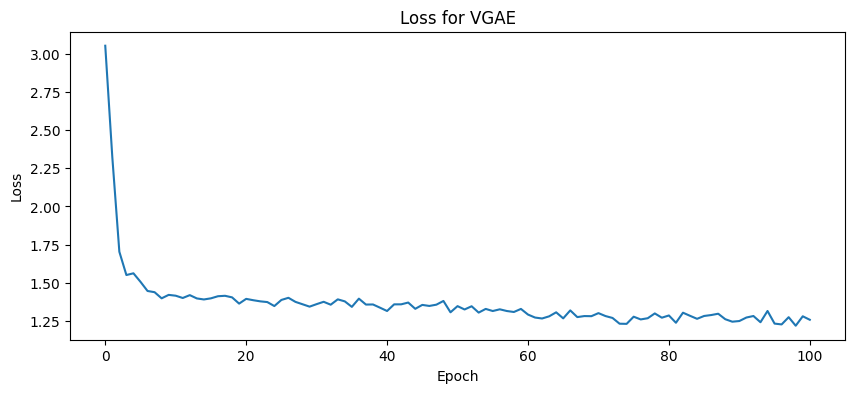

In [58]:
explainer =  copy.deepcopy(explainer_backup)

optimizer = torch.optim.Adam(explainer.parameters(), lr=0.01)
num_epochs = 100

# List for plots
losses = []

# Set the explainer to training mode
explainer.train()

# Training loop
for epoch in range(num_epochs+1):
    # Initialize variables for tracking loss and accuracy
    total_loss = 0
    
    # Iterate over the batches in the train_loader
    for graphs in ground_truth_train_loader:
        # Reset the gradients
        optimizer.zero_grad()

        # Encode the input
        z = explainer.encode(graph.x, graph.edge_index)
        
        # Calculate the loss
        loss = explainer.recon_loss(z, graph.edge_index)
        loss = loss + (1 / graph.num_nodes) * explainer.kl_loss()
    
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Update the total loss
        total_loss += loss.item()

    # Calculate the average loss for the epoch
    avg_loss = total_loss / len(ground_truth_train_loader)
    losses.append(avg_loss)
    
    # Print the epoch number, loss, and accuracy
    if epoch == num_epochs:
        print(f"Epoch {epoch}/{num_epochs}: Loss = {avg_loss:.4f}")

# Plot the loss and accuracy
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title("Loss for VGAE")
plt.xlabel("Epoch")
plt.ylabel("Loss")

## Test the explainer


In [59]:
# Set the model to evaluation mode
explainer.eval()

# Initialize variables for tracking loss and accuracy
total_loss = 0

# Iterate over the batches in the test_loader
for graph in ground_truth_test_loader:
    
    # Encode the input
    z = explainer.encode(graph.x, graph.edge_index)
           
    # Calculate the loss
    loss = explainer.recon_loss(z, graph.edge_index)
    loss = loss + (1 / graph.num_nodes) * explainer.kl_loss()
    
    # Update the total loss
    total_loss += loss.item()
    
# Calculate the average loss and accuracy for the test set
avg_loss = total_loss / len(ground_truth_test_loader)

# Print the average loss and accuracy
print(f"Test Loss: {avg_loss:.4f}")

Test Loss: 1.2560


# Check the accuracy of _Gem_


In [60]:
# Initialize variables for tracking loss and accuracy
total_loss = 0
total_accuracy = 0

# Iterate over the batches in the test_loader
for graph in test_loader:
    
    # Create the adjacency matrix
    z = explainer.encode(graph.x, graph.edge_index)
    A = explainer.decode(z)
    
    # Create a subgraph
    subgraph = copy.deepcopy(graph)
    subgraph.edge_index = A.nonzero().t().contiguous()

    # Forward pass
    output = model(subgraph)

    # Calculate the loss and the accuracy
    loss = criterion(output, graph.y)
    
    # Update the total loss
    total_loss += loss.item()

    # Calculate the accuracy
    pred_y = output.argmax(dim=1)
    acc = accuracy(pred_y, graph.y)
    
    # Update the total accuracy
    total_accuracy += acc.item()
       
# Calculate the average loss and accuracy for the test set
avg_loss = total_loss / len(test_loader)
avg_accuracy = total_accuracy / len(test_loader)

# Print the average loss and accuracy
print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_accuracy:.4f}")

Test Loss: 0.6832, Test Accuracy: 0.6094
